# IMERG quantiles

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [56]:
import math

import ocha_stratus as stratus
import matplotlib.pyplot as plt

from src.datasources import ibtracs
from src.constants import *

## Load data

In [5]:
df_storms = ibtracs.load_storms()

In [7]:
blob_name = f"{PROJECT_PREFIX}/processed/impact/emdat_cerf_upto2024.parquet"
df_impact = stratus.load_parquet_from_blob(blob_name)
df_impact["cerf"] = ~df_impact["Amount in US$"].isnull()
cols = ["sid", "cerf", "Total Affected"]
df_impact = df_impact[cols]

In [44]:
blob_name = f"{PROJECT_PREFIX}/processed/storm_stats/zma_stats.parquet"

df_stats_raw_meanonly = stratus.load_parquet_from_blob(blob_name)

In [33]:
blob_name = (
    f"{PROJECT_PREFIX}/processed/storm_stats/zma_stats_imerg_quantiles.parquet"
)

df_stats_raw = stratus.load_parquet_from_blob(blob_name)

In [34]:
df_stats_raw

,sid,valid_time_min,valid_time_max,wind_speed_max,q50_total,q50_roll2,q50_roll3,q80_total,q80_roll2,q80_roll3,q90_total,q90_roll2,q90_roll3,q95_total,q95_roll2,q95_roll3,q99_total,q99_roll2,q99_roll3
388,2000233N12316,2000-08-24 00:00:00.000040,2000-08-24 12:00:00.000040,40.0,18.190000,18.152500,18.189999,35.830003,35.588001,35.830002,46.248497,45.373501,46.248497,54.451998,53.436249,54.452000,66.406698,66.313896,66.406700
389,2000259N20273,2000-09-16 00:00:00.000040,2000-09-16 12:00:00.000040,55.0,7.749999,5.687500,7.749999,23.514002,20.615002,23.514002,55.725500,45.454998,55.725498,198.752262,198.074738,198.752258,601.477020,583.567200,601.476990
390,2000260N15308,2000-09-19 12:00:00.000040,2000-09-21 00:00:00.000040,30.0,28.482501,21.250000,23.750000,69.307002,57.465000,63.026997,109.906992,101.519501,104.777496,135.362743,126.502251,129.048248,177.652948,167.547638,173.454788
391,2001303N13276,2001-11-03 00:00:00.000040,2001-11-05 06:00:00.000040,120.0,138.927505,76.807495,112.637497,252.810013,196.168976,223.867996,316.176468,275.528503,294.610962,359.474268,316.773743,331.768250,413.908712,379.588867,390.244812
392,2002258N10300,2002-09-18 18:00:00.000040,2002-09-22 00:00:00.000040,110.0,108.217499,40.644997,56.139999,228.351990,96.101990,138.363983,319.502991,160.391495,215.725494,519.295245,390.434479,430.520508,853.606342,650.347717,724.066223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,2024216N20284,2024-08-02 12:00:00.000039,2024-08-04 00:00:00.000039,35.0,54.164997,40.412502,49.295002,100.519991,67.569000,89.244003,138.085010,118.407990,128.767014,169.710000,150.748505,156.888000,232.989563,215.226379,222.375443
469,2024268N17278,2024-09-24 06:00:00.000039,2024-09-26 06:00:00.000039,75.0,36.652500,21.440001,29.037498,122.996997,96.369003,111.023003,193.202472,153.684006,189.156494,233.762012,189.857498,227.883011,289.747283,246.513580,282.273987
470,2024279N21265,2024-10-09 02:05:00.000035,2024-10-09 06:00:00.000039,140.0,3.727500,2.845000,3.727500,8.423999,7.475000,8.424000,12.719999,10.513499,12.719999,16.262250,14.040751,16.262251,25.064249,22.692348,25.064249
471,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 12:00:00.000039,75.0,12.205000,9.135000,12.029999,33.451001,22.595999,33.451000,67.497000,60.556503,66.997490,159.121494,129.257507,148.582474,439.478544,427.730560,435.983795


In [47]:
df_stats = (
    df_stats_raw.merge(df_stats_raw_meanonly[["sid", "max_roll2_mean"]])
    .merge(df_storms)
    .merge(df_impact, how="left")
)
# note we have to set type as "boolean" (NOT bool) to get the desired behaviour here,
# without throwing warnings
df_stats["cerf"] = df_stats["cerf"].astype("boolean").fillna(False)

In [49]:
df_stats

,sid,valid_time_min,valid_time_max,wind_speed_max,q50_total,q50_roll2,q50_roll3,q80_total,q80_roll2,q80_roll3,...,max_roll2_mean,storm_id,atcf_id,season,number,name,provisional,created_at,cerf,Total Affected
0,2000233N12316,2000-08-24 00:00:00.000040,2000-08-24 12:00:00.000040,40.0,18.190000,18.152500,18.189999,35.830003,35.588001,35.830002,...,21.746411,f7ca529b-1934-4e43-a012-0241f142ac82,AL072000,2000,67,DEBBY,False,2025-05-13 23:12:11.828324,False,NaN
1,2000259N20273,2000-09-16 00:00:00.000040,2000-09-16 12:00:00.000040,55.0,7.749999,5.687500,7.749999,23.514002,20.615002,23.514002,...,33.322004,5bd0f222-9499-44d0-bca6-f41ade34425f,AL112000,2000,81,GORDON,False,2025-05-13 23:12:11.828324,False,NaN
2,2000260N15308,2000-09-19 12:00:00.000040,2000-09-21 00:00:00.000040,30.0,28.482501,21.250000,23.750000,69.307002,57.465000,63.026997,...,36.629167,4bed739e-7c59-4a64-965e-ea6e6053f210,AL122000,2000,83,HELENE,False,2025-05-13 23:12:11.828324,False,NaN
3,2001303N13276,2001-11-03 00:00:00.000040,2001-11-05 06:00:00.000040,120.0,138.927505,76.807495,112.637497,252.810013,196.168976,223.867996,...,120.507424,76965add-b379-412f-a169-656ced9e36aa,AL152001,2001,88,MICHELLE,False,2025-05-13 23:12:11.828324,False,5900012.0
4,2002258N10300,2002-09-18 18:00:00.000040,2002-09-22 00:00:00.000040,110.0,108.217499,40.644997,56.139999,228.351990,96.101990,138.363983,...,81.429310,029a08e1-1729-4c36-b7ec-20caec8a0274,AL102002,2002,68,ISIDORE,False,2025-05-13 23:12:11.828324,False,42500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2024216N20284,2024-08-02 12:00:00.000039,2024-08-04 00:00:00.000039,35.0,54.164997,40.412502,49.295002,100.519991,67.569000,89.244003,...,43.101876,0cb90303-8912-465c-be27-629f62da4796,AL042024,2024,36,DEBBY,False,2025-05-13 23:12:11.828324,False,NaN
81,2024268N17278,2024-09-24 06:00:00.000039,2024-09-26 06:00:00.000039,75.0,36.652500,21.440001,29.037498,122.996997,96.369003,111.023003,...,51.583454,fe7f99ba-a789-4f6c-96cf-769370f377d0,AL092024,2024,62,HELENE,False,2025-05-13 23:12:11.828324,False,NaN
82,2024279N21265,2024-10-09 02:05:00.000035,2024-10-09 06:00:00.000039,140.0,3.727500,2.845000,3.727500,8.423999,7.475000,8.424000,...,4.291707,fa53e725-039b-4a36-bfa6-b7f768c08022,AL142024,2024,72,MILTON,False,2025-05-13 23:12:11.828324,False,NaN
83,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 12:00:00.000039,75.0,12.205000,9.135000,12.029999,33.451001,22.595999,33.451000,...,26.294549,9522080e-6ef4-487e-a770-77a1a984dbd6,AL162024,2024,75,OSCAR,False,2025-05-13 23:12:11.828324,True,320000.0


<Axes: >

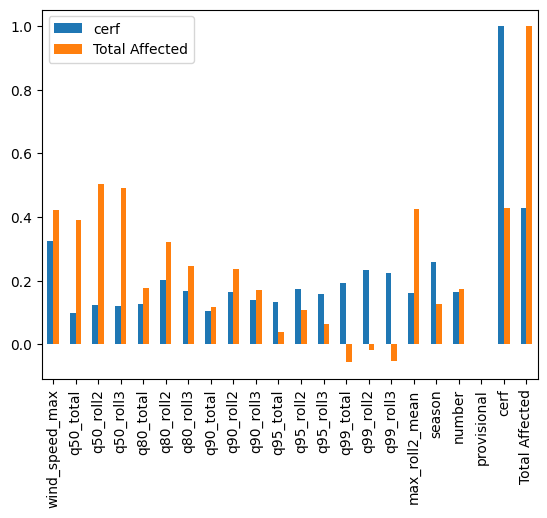

In [50]:
df_stats.corr(numeric_only=True)[["cerf", "Total Affected"]].plot(kind="bar")

In [54]:
rain_cols = [x for x in df_stats.columns if x.startswith("q")] + [
    "max_roll2_mean"
]

In [57]:
target_rp = 4
total_years = df_stats["season"].nunique()
target_year_count = math.floor((total_years + 1) / target_rp)

In [58]:
target_year_count

6